In [13]:
import numpy as np
from scipy.stats import t

## Helper function, to estimate t distribution degrees of freedom    
## Define the negative log likelihood function for the t-distribution, tested for a given degree of freedom (df)
def neg_log_likelihood(df, data):
    # We will take our mean and std as the empirical values from the provided data
    return -np.sum(t.logpdf(data, df, data.mean(), data.std()))

Monte Carlo simulation for NVDA in 2024, going up to 03/01/24.
Simulating 42 days of returns.
***********  2023 STATISTICS  ***************
Log Return Drift (Mean Daily Return): 0.004986155637547568
Log Return Variance (Mean Daily Standard Deviation): 0.02947715670396004

Annualized Average Log Return: 1.2415527537493443
Annualized Standard Deviation of Log Returns: 0.4651416870912607


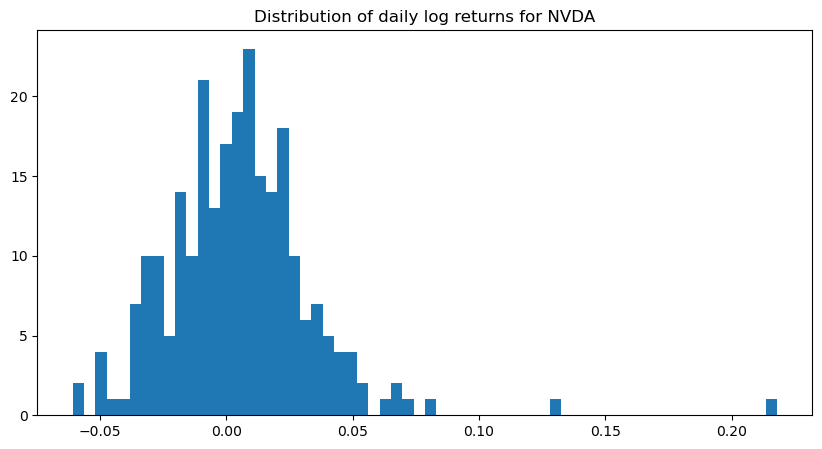

KS Statistic: 0.073405436541092
P-value: 0.12998478212514697
The data follows a normal distribution (fail to reject H0).
***********  2024 MONTE CARLO SIMULATION STATISTICS  ***************


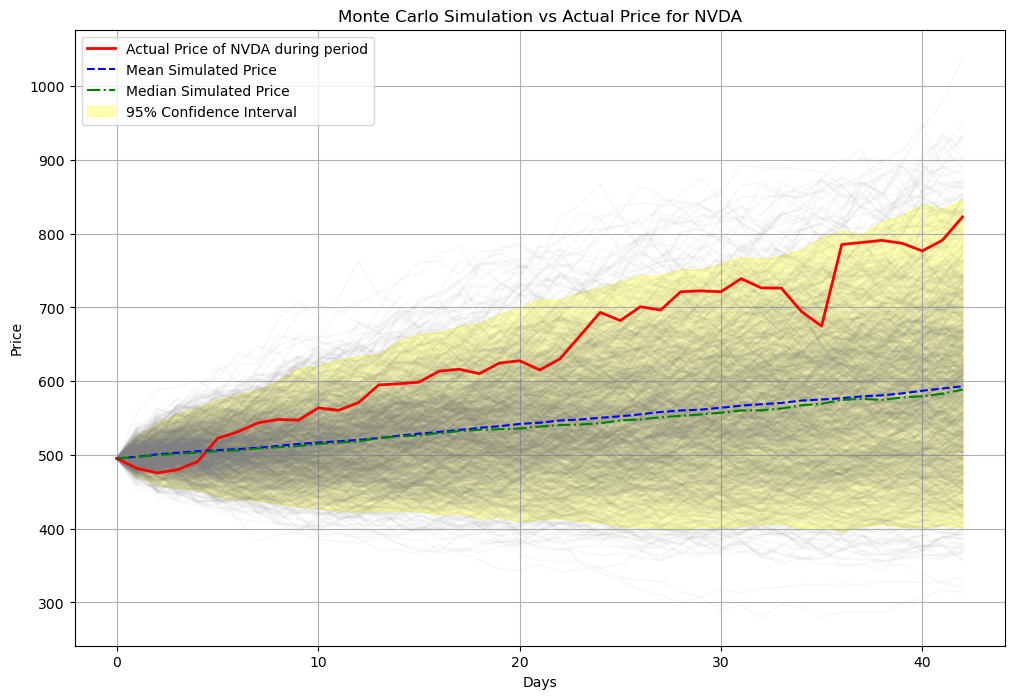

In [31]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, optimize

np.random.seed(42)  ## for reproducible results

## Basic workflow to use:
## 1. Test price data to ensure returns are lognormal; if not, model Monte Carlo simulation as draws from t distribution instead.
## 2. Estimate parameters for Monte Carlo Simulation from returns on train period (we can use last year, 2023)
## 3. Run simulation for extended number of trials over variety of frequencies; report and plot result over a test period

## One Company Workflow. Test period is YTD returns.

test_ticker = 'NVDA'
train_data_start_date = '2023-01-01'
train_data_end_date = '2024-01-01'
test_data_start_date = '2024-01-01'
test_data_end_date = '2025-01-01'

data = yf.Ticker(test_ticker).history(start=train_data_start_date, 
                                      end=train_data_end_date)
daily_log_ret = (np.log(data['Close']) - np.log(data['Close'].shift(1))).dropna()

## This is the 2024 YTD data we are aiming to simulate
test_data = yf.Ticker(test_ticker).history(start=test_data_start_date,
                                           end=test_data_end_date)
actual_prices = test_data['Close']

print(f"Monte Carlo simulation for {test_ticker} in 2024, going up to {test_data.index[-1].strftime('%D')}.")
print(f"Simulating {len(test_data)} days of returns.")

print("***********  2023 STATISTICS  ***************")

## Perform the one-sample K-S test for normal distribution with empirical parameters
ks_statistic, p_value = stats.kstest(daily_log_ret, 'norm', args=(daily_log_ret.mean(), daily_log_ret.std()))

## Print the results
print(f'Log Return Drift (Mean Daily Return): {daily_log_ret.mean()}')
print(f'Log Return Variance (Mean Daily Standard Deviation): {daily_log_ret.std()}\n')

## Number of trading days of return we are calculating from
trading_days = len(daily_log_ret)

## Print the annualized figures
print(f"Annualized Average Log Return: {daily_log_ret.mean() * trading_days}")
print(f"Annualized Standard Deviation of Log Returns: {daily_log_ret.std() * np.sqrt(trading_days)}")

plt.figure(figsize=(10,5))
plt.hist(daily_log_ret, bins=int(len(daily_log_ret)/4))
plt.title(f"Distribution of daily log returns for {test_ticker}")
plt.show()

print(f'KS Statistic: {ks_statistic}')
print(f'P-value: {p_value}')

## Interpret the results
alpha = 0.05  # Significance level for normality assumption
if p_value < alpha:
    print("The data is not normally distributed (reject H0).")
    
    ## We now want to estimate the degrees of freedom for the t-distribution to be drawn from
    ## in the simulation. For this t-distribution, we will assume the mean and standard deviation
    ## is the empirically observed variants.

    ## Initial guess for df degrees of freedom
    initial_guess = 10

    ## Optimize the negative log likelihood function
    result = optimize.minimize(neg_log_likelihood, initial_guess, args=(daily_log_ret,), bounds=[(2, 300)])

    ## Extract the estimated DF
    estimated_df = result.x[0]

    print(f"Estimated degrees of freedom for a t-distribution: {estimated_df}")
else:
    print("The data follows a normal distribution (fail to reject H0).")
    
print("***********  2024 MONTE CARLO SIMULATION STATISTICS  ***************")

## Parameters for Monte Carlo Simulation
S0 = data['Close'][-1]         ## Initial stock price
T = len(test_data)           # Timeframe in days (i.e. # of trading days so far in the year)
mu = daily_log_ret.mean()  # Estimated daily mean of log returns
sigma = daily_log_ret.std()  # Estimated daily standard deviation of log returns
simulations = 1000  # Number of Monte Carlo simulations

## Monte Carlo Simulation of Log Returns
if p_value < alpha: ## Data is not normally distributed
    log_returns = t.rvs(estimated_df, loc=drift, scale=sigma, size=(T, simulations))
else:
    log_returns = np.random.normal(drift, sigma, (T, simulations))

## Adding the 0th day to show progression from 2023 year-end price    
day_0 = np.zeros((1, simulations))
log_returns = np.vstack((day_0,log_returns))    
    
stock_prices = S0 * np.exp(np.cumsum(log_returns, axis=0))  ## Cumulative sum log returns to simulate paths

## Calculate statistics from the simulated paths
mean_prices = np.mean(stock_prices, axis=1)
median_prices = np.median(stock_prices, axis=1)
lower_bound = np.percentile(stock_prices, 2.5, axis=1)
upper_bound = np.percentile(stock_prices, 97.5, axis=1)

## Plotting the simulated paths and the actual path in comparison
plt.figure(figsize=(12,8))
plt.plot(stock_prices, color='gray', alpha=0.05)  ## Simulated prices, faded
plt.plot([S0] + list(actual_prices), label=f'Actual Price of {test_ticker} during period', 
         linewidth=2, color='red')  ## Actual prices

## Plot the statistics
plt.plot(mean_prices, label='Mean Simulated Price', linestyle='--', color='blue')
plt.plot(median_prices, label='Median Simulated Price', linestyle='-.', color='green')
plt.fill_between(range(T+1), lower_bound, upper_bound, color='yellow', alpha=0.3, 
                 label='95% Confidence Interval')

plt.title(f'Monte Carlo Simulation vs Actual Price for {test_ticker}')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [ ]:
## Ideas for next steps:
## 1. Build interface for entering tickers, modes of prediction (testing, or prediction into the future)
## 2. More robust estimation of simulation parameters: i.e. estimation of drift term, volatility term
## 2*. For drift, research methods, potentially incorporate risk factors and interest rates
## 2**. For volatility, research these methods as well, gather historical options implied volatility, other ways to estimate vol
## such as GARCH, RiskMetrics

In [20]:
## Widget/GUI Boilerplate Code, to improve with own code from above
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

# Example unction to perform Monte Carlo Simulation
def monte_carlo_simulation(stock_price, days, mu, sigma, simulations):
    dt = 1  # time increment
    price_paths = np.zeros((days, simulations))
    price_paths[0] = stock_price
    for t in range(1, days):
        random_shock = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt), size=simulations)
        price_paths[t] = price_paths[t - 1] * np.exp(random_shock)
    return price_paths

# GUI components
stock_input = widgets.FloatText(value=100, description='Stock Price:', disabled=False)
days_input = widgets.IntText(value=252, description='Days:', disabled=False)
mu_input = widgets.FloatText(value=0.05, description='Drift (mu):', disabled=False)
simulation_input = widgets.IntText(value=1000, description='#Simulations:', disabled=False)
simulate_button = widgets.Button(description="Simulate")

# Output widget for the simulation results
output = widgets.Output()

# Simulation function on button click
def on_simulate_clicked(b):
    with output:
        output.clear_output()
        stock_price = stock_input.value
        days = days_input.value
        mu = mu_input.value
        sigma = sigma_input.value
        simulations = simulation_input.value
        simulated_prices = monte_carlo_simulation(stock_price, days, mu, sigma, simulations)
        for i in range(simulated_prices.shape[1]):
            plt.plot(simulated_prices[:, i], linewidth=1)
        plt.title(f'Monte Carlo Simulation of Stock Prices over {simulations} simulations')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.show()

# Link the button to the function
simulate_button.on_click(on_simulate_clicked)

# Display GUI components
display(stock_input, days_input, mu_input, sigma_input, simulation_input, simulate_button, output)

FloatText(value=100.0, description='Stock Price:')

IntText(value=252, description='Days:')

FloatText(value=0.05, description='Drift (mu):')

FloatText(value=0.02, description='Volatility (sigma):')

IntText(value=1000, description='#Simulations:')

Button(description='Simulate', style=ButtonStyle())

Output()